# PUBG绝地求生聚类分析[单排]

<p>运用到的方法：Kmeans, AGG, DBSCAN

## 1、全特征聚类

In [1]:
import pandas as pd
import numpy as np
#读取数据集sampleSquad.csv
data = pd.read_csv('sampleSolo_V2.csv')
data.shape

(50000, 29)

In [2]:
# 挑选出用于聚类的特征
data_cluster = data.drop(columns=['winPlacePerc','matchDuration'])
column = data_cluster.columns
data_cluster.head()

,assists,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,rideDistance,...,headshot_rate,kill_rate,weaponsPerDistance,healsPerDistance,killsPerDistance,distance_over_weapons,distance_over_heals,distance_over_kills,healthitems,skill
0,0.0,0,0.0000,0.0,0,76.32,0.00,0.00,0.00,0.0,...,0.0,0.0,0.016575,0.000000,0.000000,60.333333,0.00,0.000000,0,0.00
1,0.0,0,208.0000,0.0,0,20.80,2.08,1.04,19.02,0.0,...,0.0,1.0,0.014710,0.000000,0.030597,67.980000,0.00,32.682692,0,1.04
2,0.0,0,49.4802,0.0,5,61.20,0.00,0.00,0.00,0.0,...,0.0,0.0,0.004041,0.005051,0.000000,247.475000,197.98,0.000000,5,0.00
3,0.0,0,0.0000,0.0,0,71.69,0.00,0.00,0.00,452.4,...,0.0,0.0,0.005219,0.000000,0.000000,191.600000,0.00,0.000000,0,0.00
4,0.0,0,313.9080,0.0,0,11.11,3.03,2.02,192.20,0.0,...,0.0,1.0,0.001837,0.000000,0.001855,544.333333,0.00,538.943894,0,2.02


In [3]:
# Z-score标准化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
data_input = ss.fit_transform(data_cluster)
data_input

array([[-0.23640421, -0.6028041 , -0.76289013, ..., -0.46857027,
        -0.58353347, -0.72773242],
       [-0.23640421, -0.6028041 ,  0.4884567 , ..., -0.44126796,
        -0.58353347,  0.22788739],
       [-0.23640421, -0.6028041 , -0.46521277, ..., -0.46857027,
         0.7690168 , -0.72773242],
       ...,
       [-0.23640421,  2.65841694,  0.27948178, ...,  3.36507804,
         1.31003691,  1.18350721],
       [-0.23640421, -0.05926726, -0.42242573, ..., -0.46857027,
        -0.04251336, -0.72773242],
       [-0.23640421, -0.6028041 , -0.76289013, ..., -0.46857027,
        -0.58353347, -0.72773242]])

### Kmeans聚类

In [4]:
# k-means聚类
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#####这里k-means的聚类数需要看上面画出的图自行判断
kmeans = KMeans(n_clusters=6)#n_clusters即为K值
data_cluster['kmeans'] = kmeans.fit_predict(data_input)
print(silhouette_score(data_input,data_cluster['kmeans']))
print(len(np.unique(data_cluster['kmeans'])))

0.3339261289468721
6


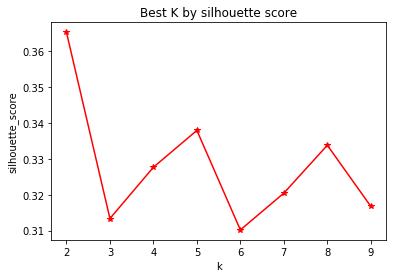

In [5]:
# K-means调参
import matplotlib.pyplot as plt
K=range(2,10)
score=[]
for k in K:
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(data_input)
    score.append(silhouette_score(data_input,kmeans.labels_,metric='euclidean'))
    
plt.plot(K,score,'r*-')
plt.xlabel('k')
plt.ylabel(u'silhouette_score')
plt.title(u'Best K by silhouette score')
plt.show()

### AGG层次聚类

In [6]:
# 层次聚类
from sklearn.cluster import AgglomerativeClustering
#####这里的distance_threshold需要自己试，试了10、100、500、300
AGG = AgglomerativeClustering(distance_threshold=300,n_clusters=None,linkage = 'ward')#distance_threshold为停止合并簇类的距离
data_cluster['agg'] = AGG.fit_predict(data_input)
print(silhouette_score(data_input,data_cluster['agg']))
print(len(np.unique(data_cluster['agg'])))

0.2995641747480561
5


In [7]:
# 采用层次聚类法得到的聚类中心，作为k-means算法的初始点
center_point = data_cluster.groupby('agg').mean()[column]# 计算聚类中心点
print(center_point)
#####这里k-means的聚类数需要看上面画出的图自行判断
kmeans = KMeans(n_clusters=5,init=center_point,n_init=1)#自定义k-means初始聚类中心
data_cluster['kmeans_init_by_agg'] = kmeans.fit_predict(data_input)
print(silhouette_score(data_input,data_cluster['kmeans_init_by_agg']))
print(len(np.unique(data_cluster['kmeans_init_by_agg'])))

      assists    boosts  damageDealt  headshotKills     heals  killPlace  \
agg                                                                        
0    0.064125  1.765252   165.337754       0.319602  2.099469  39.889271   
1    0.079675  2.599928   169.865964       0.300770  2.110589  30.469053   
2    0.000314  0.671206   171.082184       0.438563  0.618105  30.817063   
3    0.037767  0.291979    25.522286       0.000000  0.208406  73.084652   
4    0.162260  2.834037   290.523608       0.686767  2.890939  19.037808   

        kills  killStreaks  longestKill  rideDistance  ...  headshot_rate  \
agg                                                    ...                  
0    1.348674     0.589748    35.893975   1861.450687  ...       0.120687   
1    1.347477     0.700076    37.680956   4384.138660  ...       0.142086   
2    1.503852     1.100393    25.132596     60.464112  ...       0.302112   
3    0.000000     0.000000     0.000000    130.550973  ...       0.000000   
4    

### DBSCAN聚类

In [8]:
#DBSCAN聚类
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
DB = DBSCAN(eps=10,min_samples=20)#eps为密度半径
data_cluster['dbscan'] = DB.fit_predict(data_input)
print(silhouette_score(data_input,data_cluster['dbscan']))
print(len(np.unique(data_cluster['dbscan'])))

0.6268244371053118
4


DBSCAN聚类的效果最好，因此对DBSCAN方法进行深入调参

In [10]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
res = []
# 迭代不同的eps值
for eps in np.arange(6,10,1):
    # 迭代不同的min_samples值
    for min_samples in np.arange(10,20,5):
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        # 模型拟合
        db_pre = dbscan.fit_predict(data_input)
        #统计轮廓系数
        k = silhouette_score(data_input,db_pre)
        clu_num = len(np.unique(db_pre))
        res.append({'eps':eps,'min_samples':min_samples,'score':k, 'clu_num':clu_num})
# 将迭代后的结果存储到数据框中        
df = pd.DataFrame(res)

df

,eps,min_samples,score,clu_num
0,6,10,0.498131,6
1,6,15,0.498247,6
2,7,10,0.500440,6
3,7,15,0.499985,6
4,8,10,0.500857,6
5,8,15,0.500971,6
6,9,10,0.500579,6
7,9,15,0.500656,6


在4个簇类中（表格中的簇类结果包含-1），选择轮廓系数最好的参数组合为：eps=9,min_samples=15

In [11]:
#DBSCAN聚类
# 选择上面调参得出的最佳表现的参数组合进行聚类
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
DB = DBSCAN(eps=9,min_samples=15)#eps为密度半径
data['dbscan'] = DB.fit_predict(data_input)
print(silhouette_score(data_input,data['dbscan']))
print(len(np.unique(data['dbscan'])))

0.500656038127372
6


In [12]:
data['dbscan'].value_counts()

 0    48961
 1      530
 2      218
 3      154
-1       82
 4       55
Name: dbscan, dtype: int64

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   assists                50000 non-null  float64
 1   boosts                 50000 non-null  int64  
 2   damageDealt            50000 non-null  float64
 3   headshotKills          50000 non-null  float64
 4   heals                  50000 non-null  int64  
 5   killPlace              50000 non-null  float64
 6   kills                  50000 non-null  float64
 7   killStreaks            50000 non-null  float64
 8   longestKill            50000 non-null  float64
 9   matchDuration          50000 non-null  float64
 10  rideDistance           50000 non-null  float64
 11  roadKills              50000 non-null  float64
 12  swimDistance           50000 non-null  float64
 13  teamKills              50000 non-null  int64  
 14  vehicleDestroys        50000 non-null  int64  
 15  wa

In [14]:
data.to_csv('data_cluster_solo_V2.csv',index=False)

## 2、特征选择后聚类

In [1]:
import pandas as pd
import numpy as np
#读取数据集sampleSquad.csv
data = pd.read_csv('selectSolo_V2.csv')
data.shape

(50000, 13)

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   boosts                 50000 non-null  int64  
 1   damageDealt            50000 non-null  float64
 2   killPlace              50000 non-null  float64
 3   kills                  50000 non-null  float64
 4   longestKill            50000 non-null  float64
 5   walkDistance           50000 non-null  float64
 6   weaponsAcquired        50000 non-null  int64  
 7   totalDistance          50000 non-null  float64
 8   distance_over_weapons  50000 non-null  float64
 9   distance_over_kills    50000 non-null  float64
 10  healthitems            50000 non-null  int64  
 11  skill                  50000 non-null  float64
 12  winPlacePerc           50000 non-null  float64
dtypes: float64(10), int64(3)
memory usage: 5.0 MB


In [18]:
# 挑选出用于聚类的特征
data_cluster = data.drop(columns=['winPlacePerc'])
column = data_cluster.columns
data_cluster.head()

,boosts,damageDealt,killPlace,kills,longestKill,walkDistance,weaponsAcquired,totalDistance,distance_over_weapons,distance_over_kills,healthitems,skill
0,0,0.0000,76.32,0.00,0.00,181.00,3,181.00,60.333333,0.000000,0,0.00
1,0,208.0000,20.80,2.08,19.02,67.98,1,67.98,67.980000,32.682692,0,1.04
2,0,49.4802,61.20,0.00,0.00,989.90,4,989.90,247.475000,0.000000,5,0.00
3,0,0.0000,71.69,0.00,0.00,314.00,4,766.40,191.600000,0.000000,0,0.00
4,0,313.9080,11.11,3.03,192.20,1633.00,3,1633.00,544.333333,538.943894,0,2.02


In [19]:
# Z-score标准化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
data_input = ss.fit_transform(data_cluster)
data_input

array([[-0.6028041 , -0.76289013,  0.96319215, ..., -0.46857027,
        -0.58353347, -0.72773242],
       [-0.6028041 ,  0.4884567 , -0.99848437, ..., -0.44126796,
        -0.58353347,  0.22788739],
       [-0.6028041 , -0.46521277,  0.42896036, ..., -0.46857027,
         0.7690168 , -0.72773242],
       ...,
       [ 2.65841694,  0.27948178, -0.96173827, ...,  3.36507804,
         1.31003691,  1.18350721],
       [-0.05926726, -0.42242573,  0.76179524, ..., -0.46857027,
        -0.04251336, -0.72773242],
       [-0.6028041 , -0.76289013,  1.31652005, ..., -0.46857027,
        -0.58353347, -0.72773242]])

### DBSCAN聚类

In [20]:
#DBSCAN聚类
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
DB = DBSCAN(eps=2,min_samples=8)#eps为密度半径
data_cluster['dbscan'] = DB.fit_predict(data_input)
print(silhouette_score(data_input,data_cluster['dbscan']))
print(len(np.unique(data_cluster['dbscan'])))

0.6068231231469576
2


In [22]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
res = []
# 迭代不同的eps值
for eps in np.arange(2,3,0.5):
    # 迭代不同的min_samples值
    for min_samples in np.arange(3,7,1):
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        # 模型拟合
        db_pre = dbscan.fit_predict(data_input)
        #统计轮廓系数
        k = silhouette_score(data_input,db_pre)
        clu_num = len(np.unique(db_pre))
        res.append({'eps':eps,'min_samples':min_samples,'score':k, 'clu_num':clu_num})
# 将迭代后的结果存储到数据框中        
df = pd.DataFrame(res)

df

,eps,min_samples,score,clu_num
0,2.0,3,0.383299,16
1,2.0,4,0.458131,9
2,2.0,5,0.468094,4
3,2.0,6,0.547672,4
4,2.5,3,0.541238,6
5,2.5,4,0.554146,6
6,2.5,5,0.661678,3
7,2.5,6,0.667210,2


In [30]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
res = []
# 迭代不同的eps值
for eps in np.arange(2.1,2.5,0.1):
    # 迭代不同的min_samples值
    for min_samples in np.arange(4,7,1):
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        # 模型拟合
        db_pre = dbscan.fit_predict(data_input)
        #统计轮廓系数
        k = silhouette_score(data_input,db_pre)
        clu_num = len(np.unique(db_pre))
        res.append({'eps':eps,'min_samples':min_samples,'score':k, 'clu_num':clu_num})
# 将迭代后的结果存储到数据框中        
df = pd.DataFrame(res)

df

,eps,min_samples,score,clu_num
0,2.1,4,0.508548,8
1,2.1,5,0.592410,4
2,2.1,6,0.602268,3
3,2.2,4,0.578130,5
4,2.2,5,0.632466,3
5,2.2,6,0.594182,3
6,2.3,4,0.592160,6
7,2.3,5,0.645134,3
8,2.3,6,0.648510,2
9,2.4,4,0.583985,8


In [31]:
#DBSCAN聚类
# 选择上面调参得出的最佳表现的参数组合进行聚类
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
DB = DBSCAN(eps=2.2,min_samples=4)#eps为密度半径
data['dbscan'] = DB.fit_predict(data_input)
print(silhouette_score(data_input,data['dbscan']))
print(len(np.unique(data['dbscan'])))

0.5781300389173932
5


In [32]:
data['dbscan'].value_counts()

 0    49513
-1      474
 2        5
 3        4
 1        4
Name: dbscan, dtype: int64

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   boosts                 50000 non-null  int64  
 1   damageDealt            50000 non-null  float64
 2   killPlace              50000 non-null  float64
 3   kills                  50000 non-null  float64
 4   longestKill            50000 non-null  float64
 5   walkDistance           50000 non-null  float64
 6   weaponsAcquired        50000 non-null  int64  
 7   totalDistance          50000 non-null  float64
 8   distance_over_weapons  50000 non-null  float64
 9   distance_over_kills    50000 non-null  float64
 10  healthitems            50000 non-null  int64  
 11  skill                  50000 non-null  float64
 12  winPlacePerc           50000 non-null  float64
 13  dbscan                 50000 non-null  int64  
dtypes: float64(10), int64(4)
memory usage: 5.3 MB


In [34]:
data.to_csv('select_cluster_solo_V2.csv',index=False)

## 3、特征工程
该部分尝试将变量整合为4个维度进行聚类

In [1]:
import pandas as pd
import numpy as np
#读取数据集sampleSquad.csv
data = pd.read_csv('selectSolo.csv')
data.head()

,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,rideDistance,walkDistance,weaponsAcquired,winPlacePerc,totalDistance,kill_rate
0,0,107.526882,0.0,0,43.010753,1.075269,1.075269,11.220,0.0,56.82,2,0.2717,56.82,1.0
1,0,0.000000,0.0,0,98.979592,0.000000,0.000000,0.000,0.0,29.28,0,0.0103,29.28,0.0
2,0,246.562500,0.0,0,14.583333,2.083333,1.041667,43.970,0.0,3304.00,4,0.9053,3304.00,1.0
3,0,103.092784,0.0,1,40.206186,1.030928,1.030928,1.459,0.0,103.50,4,0.4062,103.50,1.0
4,6,0.000000,0.0,13,44.791667,0.000000,0.000000,0.000,0.0,3358.00,3,0.9158,3358.00,0.0


In [2]:
data_cluster = data.drop(columns=['winPlacePerc'])
column = data_cluster.columns
data_cluster['skills'] = data.headshotKills/data.headshotKills.max() + data.longestKill/data.longestKill.max() + data.killStreaks/data.killStreaks.max()
data_cluster['materials'] = data.boosts/data.boosts.max() + data.heals/data.heals.max() + data.weaponsAcquired/data.weaponsAcquired.max()
data_cluster['attack'] = data.damageDealt/data.damageDealt.max() + data.killPlace/data.killPlace.max() + data.kills/data.kills.max()
data_cluster['distance'] = data.totalDistance
data_cluster

,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,rideDistance,walkDistance,weaponsAcquired,totalDistance,kill_rate,skills,materials,attack,distance
0,0,107.526882,0.0,0,43.010753,1.075269,1.075269,11.220,0.0,56.82,2,56.82,1.0,0.100100,0.095238,0.531628,56.82
1,0,0.000000,0.0,0,98.979592,0.000000,0.000000,0.000,0.0,29.28,0,29.28,0.0,0.000000,0.000000,0.989796,29.28
2,0,246.562500,0.0,0,14.583333,2.083333,1.041667,43.970,0.0,3304.00,4,3304.00,1.0,0.146434,0.190476,0.360463,3304.00
3,0,103.092784,0.0,1,40.206186,1.030928,1.030928,1.459,0.0,103.50,4,103.50,1.0,0.082077,0.209707,0.499395,103.50
4,6,0.000000,0.0,13,44.791667,0.000000,0.000000,0.000,0.0,3358.00,3,3358.00,0.0,0.000000,0.607143,0.447917,3358.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,28.126316,0.0,0,80.000000,0.000000,0.000000,0.000,0.0,252.70,1,252.70,0.0,0.000000,0.047619,0.813195,252.70
49996,0,26.597938,0.0,1,63.917526,0.000000,0.000000,0.000,0.0,534.20,4,534.20,0.0,0.000000,0.209707,0.651653,534.20
49997,2,52.833333,0.0,0,55.208333,0.000000,0.000000,0.000,0.0,2010.00,4,2010.00,0.0,0.000000,0.261905,0.576869,2010.00
49998,1,281.368421,0.0,2,21.052632,2.105263,1.052632,22.310,0.0,1082.00,3,1082.00,1.0,0.114917,0.217033,0.442526,1082.00


In [3]:
data_cluster = data_cluster.drop(columns=column)
data_cluster

,skills,materials,attack,distance
0,0.100100,0.095238,0.531628,56.82
1,0.000000,0.000000,0.989796,29.28
2,0.146434,0.190476,0.360463,3304.00
3,0.082077,0.209707,0.499395,103.50
4,0.000000,0.607143,0.447917,3358.00
...,...,...,...,...
49995,0.000000,0.047619,0.813195,252.70
49996,0.000000,0.209707,0.651653,534.20
49997,0.000000,0.261905,0.576869,2010.00
49998,0.114917,0.217033,0.442526,1082.00


In [4]:
# Z-score标准化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
data_input = ss.fit_transform(data_cluster)
data_input

array([[ 0.09795106, -0.74435617, -0.38760966, -0.7127721 ],
       [-0.67487669, -1.28533105,  1.88978857, -0.7270583 ],
       [ 0.45568338, -0.20338128, -1.23840997,  0.97168221],
       ...,
       [-0.67487669,  0.20234989, -0.16272799,  0.3004278 ],
       [ 0.21235193, -0.05253251, -0.83050116, -0.18096639],
       [ 0.12617916, -1.01484361, -0.41572177, -0.64819887]])

### 特征工程后再进行聚类

In [5]:
#DBSCAN聚类
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
DB = DBSCAN(eps=2,min_samples=2.5)#eps为密度半径
data_cluster['dbscan'] = DB.fit_predict(data_input)
print(silhouette_score(data_input,data_cluster['dbscan']))
print(len(np.unique(data_cluster['dbscan'])))

0.7822912279167679
3


In [8]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
res = []
# 迭代不同的eps值
for eps in np.arange(1.1,2.3,0.2):
    # 迭代不同的min_samples值
    for min_samples in np.arange(1.5,2,0.1):
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        # 模型拟合
        db_pre = dbscan.fit_predict(data_input)
        #统计轮廓系数
        k = silhouette_score(data_input,db_pre)
        clu_num = len(np.unique(db_pre))
        res.append({'eps':eps,'min_samples':min_samples,'score':k, 'clu_num':clu_num})
# 将迭代后的结果存储到数据框中        
df = pd.DataFrame(res)

df

,eps,min_samples,score,clu_num
0,1.1,1.5,0.627670,10
1,1.1,1.6,0.627670,10
2,1.1,1.7,0.627670,10
3,1.1,1.8,0.627670,10
4,1.1,1.9,0.627670,10
5,1.3,1.5,0.669266,6
6,1.3,1.6,0.669266,6
7,1.3,1.7,0.669266,6
8,1.3,1.8,0.669266,6
9,1.3,1.9,0.669266,6


In [11]:
#DBSCAN聚类
# 选择上面调参得出的最佳表现的参数组合进行聚类
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
DB = DBSCAN(eps=1.7,min_samples=1.9)#eps为密度半径
data['dbscan'] = DB.fit_predict(data_input)
print(silhouette_score(data_input,data['dbscan']))
print(len(np.unique(data['dbscan'])))

0.7315113601688956
5


In [12]:
data['dbscan'].value_counts()

 0    49973
-1       20
 1        3
 3        2
 2        2
Name: dbscan, dtype: int64

各类分布严重不均，聚类效果较差

## 4、带因变量聚类
该部分尝试将因变量放入聚类方法中

In [35]:
import pandas as pd
import numpy as np
#读取数据集sampleSquad.csv
data = pd.read_csv('sampleSolo_V2.csv')
data.shape

(50000, 29)

In [37]:
# 挑选出用于聚类的特征
data_cluster = data.drop(columns=['matchDuration'])
column = data_cluster.columns
data_cluster.head()

,assists,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,rideDistance,...,headshot_rate,kill_rate,weaponsPerDistance,healsPerDistance,killsPerDistance,distance_over_weapons,distance_over_heals,distance_over_kills,healthitems,skill
0,0.0,0,0.0000,0.0,0,76.32,0.00,0.00,0.00,0.0,...,0.0,0.0,0.016575,0.000000,0.000000,60.333333,0.00,0.000000,0,0.00
1,0.0,0,208.0000,0.0,0,20.80,2.08,1.04,19.02,0.0,...,0.0,1.0,0.014710,0.000000,0.030597,67.980000,0.00,32.682692,0,1.04
2,0.0,0,49.4802,0.0,5,61.20,0.00,0.00,0.00,0.0,...,0.0,0.0,0.004041,0.005051,0.000000,247.475000,197.98,0.000000,5,0.00
3,0.0,0,0.0000,0.0,0,71.69,0.00,0.00,0.00,452.4,...,0.0,0.0,0.005219,0.000000,0.000000,191.600000,0.00,0.000000,0,0.00
4,0.0,0,313.9080,0.0,0,11.11,3.03,2.02,192.20,0.0,...,0.0,1.0,0.001837,0.000000,0.001855,544.333333,0.00,538.943894,0,2.02


In [38]:
# Z-score标准化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
data_input = ss.fit_transform(data_cluster)
data_input

array([[-0.23640421, -0.6028041 , -0.76289013, ..., -0.46857027,
        -0.58353347, -0.72773242],
       [-0.23640421, -0.6028041 ,  0.4884567 , ..., -0.44126796,
        -0.58353347,  0.22788739],
       [-0.23640421, -0.6028041 , -0.46521277, ..., -0.46857027,
         0.7690168 , -0.72773242],
       ...,
       [-0.23640421,  2.65841694,  0.27948178, ...,  3.36507804,
         1.31003691,  1.18350721],
       [-0.23640421, -0.05926726, -0.42242573, ..., -0.46857027,
        -0.04251336, -0.72773242],
       [-0.23640421, -0.6028041 , -0.76289013, ..., -0.46857027,
        -0.58353347, -0.72773242]])

In [39]:
#DBSCAN聚类
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
DB = DBSCAN(eps=10,min_samples=20)#eps为密度半径
data_cluster['dbscan'] = DB.fit_predict(data_input)
print(silhouette_score(data_input,data_cluster['dbscan']))
print(len(np.unique(data_cluster['dbscan'])))

0.6168258354598308
4


In [40]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
res = []
# 迭代不同的eps值
for eps in np.arange(6,10,1):
    # 迭代不同的min_samples值
    for min_samples in np.arange(10,20,5):
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        # 模型拟合
        db_pre = dbscan.fit_predict(data_input)
        #统计轮廓系数
        k = silhouette_score(data_input,db_pre)
        clu_num = len(np.unique(db_pre))
        res.append({'eps':eps,'min_samples':min_samples,'score':k, 'clu_num':clu_num})
# 将迭代后的结果存储到数据框中        
df = pd.DataFrame(res)

df

,eps,min_samples,score,clu_num
0,6,10,0.484715,6
1,6,15,0.484828,6
2,7,10,0.487096,6
3,7,15,0.486630,6
4,8,10,0.487534,6
5,8,15,0.487646,6
6,9,10,0.487261,6
7,9,15,0.487337,6


In [41]:
#DBSCAN聚类
# 选择上面调参得出的最佳表现的参数组合进行聚类
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
DB = DBSCAN(eps=9,min_samples=15)#eps为密度半径
data['dbscan'] = DB.fit_predict(data_input)
print(silhouette_score(data_input,data['dbscan']))
print(len(np.unique(data['dbscan'])))

0.4873365578726908
6


In [42]:
data['dbscan'].value_counts()

 0    48961
 1      530
 2      218
 3      154
-1       82
 4       55
Name: dbscan, dtype: int64

各类分布依旧不均，聚类效果较差